# The Echo Room — Dual-Lens Emotion Interpretation with LLMs

This notebook contains the full implementation of **The Echo Room**, a project that detects the intended emotion of an author and prepares for analyzing the perceived emotion from a reader.  

In this submission, I train a **10-class transformer classifier** on the **GoEmotions** dataset (author perspective) and prepare the **EmpatheticDialogues** dataset (reader perspective) for future modeling.  

Key steps:
1. Load and clean datasets  
2. Align labels to a shared set of 10 emotions  
3. Balance the label distribution (cap neutral at 10,000)  
4. Train and evaluate the author-perspective model  
5. Save results and model for future use  


# Feasibility Stage
In this stage, we set up the environment, load datasets, explore data structure, identify shared emotion labels, and run basic visualizations to understand class distributions and potential preprocessing needs.


In [ ]:
!pip install -U "transformers==4.37.2" "peft==0.10.0" "accelerate==0.27.2" --quiet

In [ ]:
import pandas as pd
import kagglehub
from datasets import load_dataset
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Load the GoEmotions dataset from uploaded CSV
goemotions_df = pd.read_csv("go_emotions_dataset.csv")
print("GoEmotions Sample:")
print(goemotions_df.sample(1))


GoEmotions Sample:
            id                                               text  \
24482  edjin31  Except the ones trying to zipper by flying by ...   

       example_very_unclear  admiration  amusement  anger  annoyance  \
24482                 False           0          0      0          0   

       approval  caring  confusion  ...  love  nervousness  optimism  pride  \
24482         0       1          0  ...     0            0         0      0   

       realization  relief  remorse  sadness  surprise  neutral  
24482            0       0        0        0         0        0  

[1 rows x 31 columns]


In [ ]:
import tarfile
import os

# Extract the tar.gz archive
with tarfile.open("empatheticdialogues.tar.gz", "r:gz") as tar:
    tar.extractall("empatheticdialogues")

# Confirm extraction
print("Files extracted to:", os.listdir("empatheticdialogues"))

Files extracted to: ['empatheticdialogues']


In [ ]:
# Load the Cleaned EmpatheticDialogues dataset with error skipping
empathetic_df = pd.read_csv("empatheticdialogues/empatheticdialogues/train.csv", on_bad_lines="skip")
print("EmpatheticDialogues Sample:")
print(empathetic_df.sample(1))



EmpatheticDialogues Sample:
                   conv_id  utterance_idx context  \
33807  hit:5408_conv:10816              2  caring   

                                                  prompt  speaker_idx  \
33807  My grandfather was diagnosed with cancer recen...          540   

                               utterance     selfeval tags  
33807  Oh my God_comma_ that's terrible.  5|5|5_4|4|4  NaN  


In [ ]:
# Show all emotion columns
emotion_columns = goemotions_df.columns[3:]  # skip 'id', 'text', 'example_very_unclear'
print("GoEmotions Emotion Labels:")
print(emotion_columns.tolist())

goemotions_label_counts = goemotions_df[emotion_columns].sum().sort_values(ascending=False)
print("\nTop 10 Emotions by Frequency:")
print(goemotions_label_counts.head(10))


GoEmotions Emotion Labels:
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

Top 10 Emotions by Frequency:
neutral        55298
approval       17620
admiration     17131
annoyance      13618
gratitude      11625
disapproval    11424
curiosity       9692
amusement       9245
realization     8785
optimism        8715
dtype: int64


In [ ]:
# Check unique labels in the 'context' column
print("EmpatheticDialogues Emotion Labels:")
print(empathetic_df['context'].unique())

print("\nLabel Frequencies:")
print(empathetic_df['context'].value_counts().head(10))


EmpatheticDialogues Emotion Labels:
['sentimental' 'afraid' 'proud' 'faithful' 'terrified' 'joyful' 'angry'
 'sad' 'jealous' 'grateful' 'prepared' 'embarrassed' 'excited' 'annoyed'
 'lonely' 'ashamed' 'guilty' 'surprised' 'nostalgic' 'confident' 'furious'
 'disappointed' 'caring' 'trusting' 'disgusted' 'anticipating' 'anxious'
 'hopeful' 'content' 'impressed' 'apprehensive' 'devastated']

Label Frequencies:
context
surprised    3956
excited      2935
angry        2740
proud        2719
annoyed      2642
sad          2634
afraid       2510
lonely       2503
grateful     2487
terrified    2487
Name: count, dtype: int64


In [ ]:
# Define shared label set
shared_emotions = [
    "joy", "anger", "sadness", "fear", "surprise",
    "disgust", "love", "gratitude", "neutral", "pride"
]

# Filter only rows with at least one shared emotion
filtered = goemotions_df[goemotions_df[shared_emotions].sum(axis=1) > 0].copy()

# For each row, pick the highest scoring (dominant) emotion
filtered["label"] = filtered[shared_emotions].idxmax(axis=1)

# Keep only text and new label
goemotions_clean = filtered[["text", "label"]].copy()
print("GoEmotions (Cleaned) Sample:")
print(goemotions_clean.sample(3))


GoEmotions (Cleaned) Sample:
                                                     text      label
30815                             What a time to be alive        joy
205185           Thanks for reminding me not to have kids  gratitude
12140   I've been getting it off from the West Wing si...    neutral


In [ ]:
# Define mapping from EmpatheticDialogues context → shared emotions
context_mapping = {
    "joyful": "joy",
    "excited": "joy",
    "content": "joy",
    "hopeful": "joy",

    "proud": "pride",
    "grateful": "gratitude",

    "angry": "anger",
    "furious": "anger",
    "annoyed": "anger",

    "afraid": "fear",
    "terrified": "fear",
    "apprehensive": "fear",

    "sad": "sadness",
    "lonely": "sadness",
    "devastated": "sadness",

    "surprised": "surprise",

    "disgusted": "disgust",

    "sentimental": "love",
    "nostalgic": "love"
}

# Map the context column
empathetic_df["label"] = empathetic_df["context"].map(context_mapping)

# Drop rows where mapping failed
empathetic_clean = empathetic_df.dropna(subset=["label"])[["utterance", "label"]].rename(columns={
    "utterance": "text"
})

# Preview sample
print("EmpatheticDialogues (Cleaned) Sample:")
print(empathetic_clean.sample(3))


EmpatheticDialogues (Cleaned) Sample:
                                                    text label
34481  It is worth a look for the new one_comma_ it l...   joy
43130  You have done such a great job! You should be ...  fear
25868            it was late and the street wasnt lit up  fear


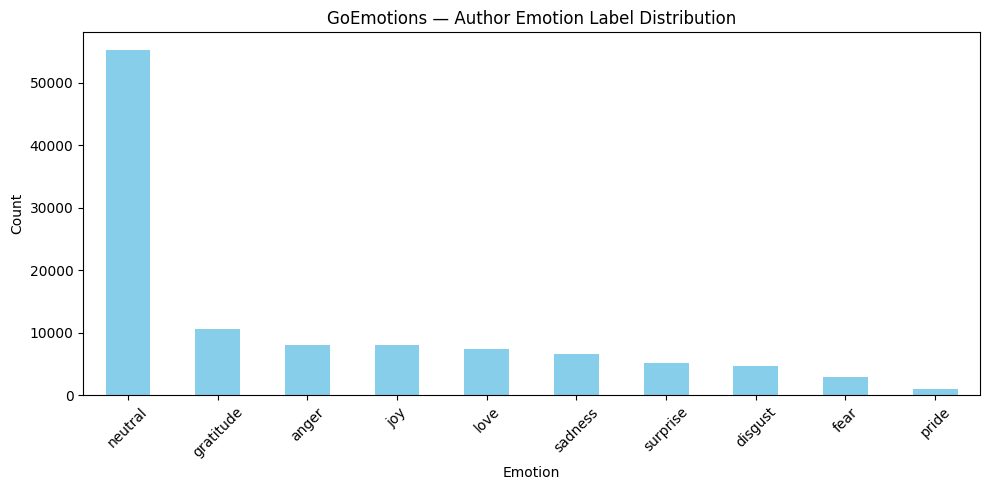

In [ ]:
import matplotlib.pyplot as plt

# Plot label distribution for GoEmotions
goemotions_clean["label"].value_counts().plot(kind="bar", figsize=(10,5), color="skyblue")
plt.title("GoEmotions — Author Emotion Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

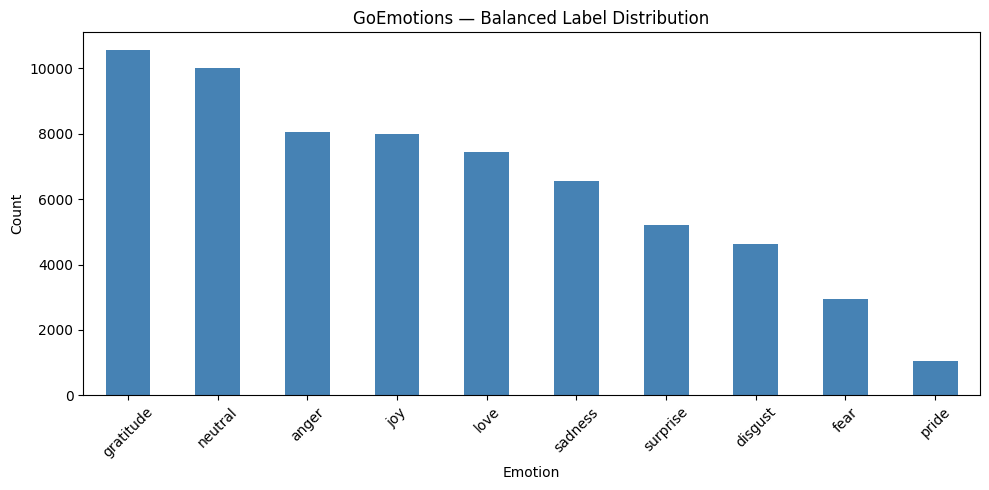

In [ ]:
# Cap for "neutral"
neutral_cap = 10000

# Split neutral and non-neutral
neutral_rows = goemotions_clean[goemotions_clean["label"] == "neutral"].sample(n=neutral_cap, random_state=42)
non_neutral_rows = goemotions_clean[goemotions_clean["label"] != "neutral"]

# Combine and shuffle
goemotions_balanced = pd.concat([neutral_rows, non_neutral_rows])
goemotions_balanced = goemotions_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

goemotions_clean = goemotions_balanced

# Plot to confirm
goemotions_clean["label"].value_counts().plot(kind="bar", figsize=(10,5), color="steelblue")
plt.title("GoEmotions — Balanced Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Balancing the Dataset
The "neutral" label was heavily overrepresented, with over 55k samples. To avoid bias in our model, we capped it at 10,000 and kept all other labels unchanged. Then we shuffled the combined data to remove any ordering.
The updated plot shows a much more balanced distribution, which helps ensure fairer learning across all emotion categories.

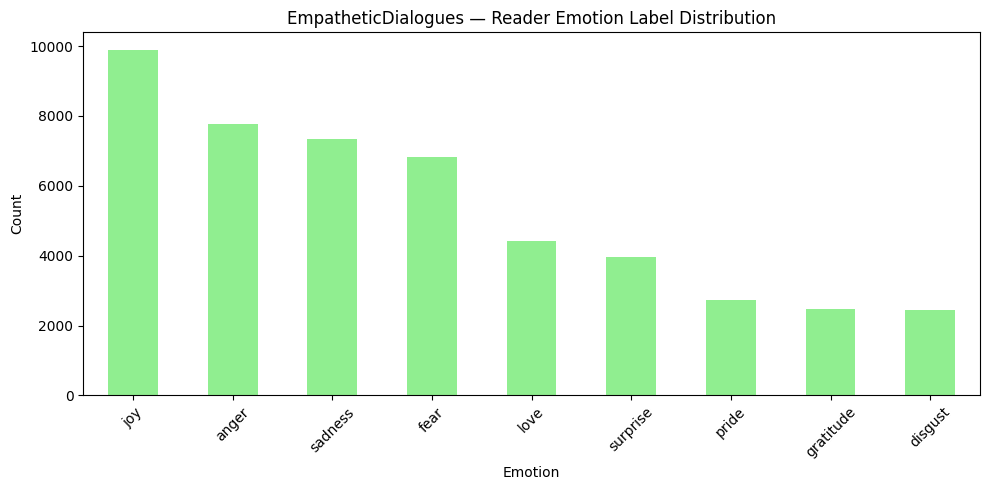

In [ ]:
# Plot label distribution for EmpatheticDialogues
empathetic_clean["label"].value_counts().plot(kind="bar", figsize=(10,5), color="lightgreen")
plt.title("EmpatheticDialogues — Reader Emotion Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Show one example per emotion for GoEmotions
print("GoEmotions: One Example Per Emotion\n")
for label in goemotions_clean["label"].unique():
    example = goemotions_clean[goemotions_clean["label"] == label]["text"].iloc[0]
    print(f"{label.upper()}: {example}")

GoEmotions: One Example Per Emotion

NEUTRAL: Oh, [NAME], don't bring THAT story up!
GRATITUDE: Thank you so much! That’s a helpful list with a great variety!
LOVE: I like this rule because in life there are always exceptions. The problem is when you start feeling entitled to *being* that exception.
DISGUST: I’m always weirded out whenever I see him without a beard because in my game I got the longest beard I could
JOY: Im glad youre going to be a perfect parent who never makes any mistakes. Make sure you write a book!
SURPRISE: Really? I thought this joke was a bit plane
ANGER: [NAME] is so pathetic, 40 year old man jealous of a 26 year old DJ
SADNESS: I’m sorry for your loss bro ❤️
PRIDE: No problem! I've been chillin in capture the flag for couple of days now and she is super strong and fun in this mode.
FEAR: My dosage was increased 2 weeks ago and I've noticed the issues getting worse. With your comment, I'm really leaning towards them being side effects.


In [ ]:
# Show one example per emotion for EmpatheticDialogues
print("\nEmpatheticDialogues: One Example Per Emotion\n")
for label in empathetic_clean["label"].unique():
    example = empathetic_clean[empathetic_clean["label"] == label]["text"].iloc[0]
    print(f"{label.upper()}: {example}")


EmpatheticDialogues: One Example Per Emotion

LOVE: I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world.
FEAR:  it feels like hitting to blank wall when i see the darkness
PRIDE: Hi how are you doing today
JOY: Hi_comma_ this year_comma_ I was the first over 300 students at my enginering school
ANGER: I lost my job last year and got really angry.
SADNESS: During christmas a few years ago_comma_ I did not get any presents.
GRATITUDE: Hi_comma_ I went to a park and I set on a bench. I didn't notice that my wallet felt. A man came to me from behind giving me back my wallet.
SURPRISE: When I was working my first job_comma_ my parents picked me up in my new car_comma_ I was very surprised_comma_ i thought I was gonna have to buy my own car
DISGUST: I hate to be tired and see a store crowded with customers and only one or two checkouts open.


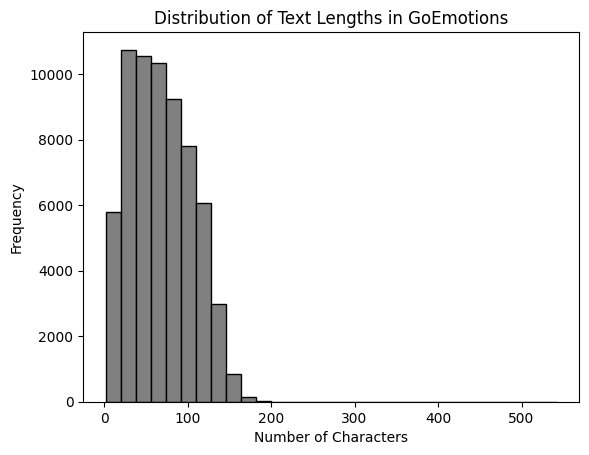

In [ ]:
# Plot distribution of text lengths for GoEmotions
goemotions_clean["length"] = goemotions_clean["text"].apply(len)
goemotions_clean["length"].plot(kind="hist", bins=30, color="gray", edgecolor="black")
plt.title("Distribution of Text Lengths in GoEmotions")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

# Prototype Stage
Here, we implement the core model pipeline: encoding labels, tokenizing text, creating dataset classes, loading a base transformer model, and running initial training and evaluation to test feasibility at scale.


In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Drop missing or non-string labels
goemotions_clean = goemotions_clean[goemotions_clean["label"].notna()]
goemotions_clean = goemotions_clean[goemotions_clean["label"].apply(lambda x: isinstance(x, str))]

# Encode the cleaned labels
label_encoder = LabelEncoder()
goemotions_clean["label_encoded"] = label_encoder.fit_transform(goemotions_clean["label"])

# Split into train/test sets
g_train_texts, g_test_texts, g_train_labels, g_test_labels = train_test_split(
    goemotions_clean["text"],
    goemotions_clean["label_encoded"],
    test_size=0.2,
    random_state=42,
    stratify=goemotions_clean["label_encoded"]
)

# Reset index and convert labels to NumPy arrays
g_train_labels = g_train_labels.reset_index(drop=True).to_numpy()
g_test_labels = g_test_labels.reset_index(drop=True).to_numpy()

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en")

# Tokenize text
g_train_encodings = tokenizer(list(g_train_texts), truncation=True, padding=True, max_length=128)
g_test_encodings = tokenizer(list(g_test_texts), truncation=True, padding=True, max_length=128)

print("Tokenization complete. Sample token IDs:")
print(g_train_encodings["input_ids"][0][:10])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Tokenization complete. Sample token IDs:
[101, 9413, 12171, 12171, 12171, 12171, 2099, 2008, 1005, 1055]


In [ ]:
import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

In [ ]:
train_dataset = EmotionDataset(g_train_encodings, g_train_labels)
test_dataset = EmotionDataset(g_test_encodings, g_test_labels)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load smaller, lighter model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en")
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained("BAAI/bge-small-en", num_labels=num_labels)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-small-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=2,       # ↓ lowered to reduce memory usage
    per_device_eval_batch_size=4,        # ↓ lowered
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=False,        # ↓ disables extra memory usage
    gradient_accumulation_steps=4        # ↑ simulate bigger batch size
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.017300,1.021110


TrainOutput(global_step=6448, training_loss=1.0616809030620395, metrics={'train_runtime': 18314.0795, 'train_samples_per_second': 2.817, 'train_steps_per_second': 0.352, 'total_flos': 544697234497416.0, 'train_loss': 1.0616809030620395, 'epoch': 1.0})

In [ ]:
results = trainer.evaluate()
print("Evaluation Results:")
print(results)


Evaluation Results:
{'eval_loss': 1.021109938621521, 'eval_runtime': 1570.7818, 'eval_samples_per_second': 8.21, 'eval_steps_per_second': 2.052, 'epoch': 1.0}


In [ ]:
model.save_pretrained("echo-room-model")
tokenizer.save_pretrained("echo-room-model")

('echo-room-model/tokenizer_config.json',
 'echo-room-model/special_tokens_map.json',
 'echo-room-model/vocab.txt',
 'echo-room-model/added_tokens.json',
 'echo-room-model/tokenizer.json')

In [ ]:
!zip -r echo-room-model.zip echo-room-model

  adding: echo-room-model/ (stored 0%)
  adding: echo-room-model/special_tokens_map.json (deflated 80%)
  adding: echo-room-model/tokenizer_config.json (deflated 75%)
  adding: echo-room-model/vocab.txt (deflated 53%)
  adding: echo-room-model/model.safetensors (deflated 12%)
  adding: echo-room-model/config.json (deflated 57%)
  adding: echo-room-model/tokenizer.json (deflated 71%)


In [ ]:
from transformers import TextClassificationPipeline

pipeline = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

texts = [
    "I'm so proud of what I accomplished today.",
    "I miss my old friends and feel really down lately.",
    "Wow, that was unexpected!",
    "I feel loved and grateful.",
    "Why would they say that to me? I'm furious!"
]

for text in texts:
    result = pipeline(text)
    print(f"\nInput: {text}")
    print("Predicted scores:", result[0])



Input: I'm so proud of what I accomplished today.
Predicted scores: [{'label': 'LABEL_0', 'score': 0.009831232018768787}, {'label': 'LABEL_1', 'score': 0.00960888247936964}, {'label': 'LABEL_2', 'score': 0.03993530198931694}, {'label': 'LABEL_3', 'score': 0.07625104486942291}, {'label': 'LABEL_4', 'score': 0.07872162759304047}, {'label': 'LABEL_5', 'score': 0.018113737925887108}, {'label': 'LABEL_6', 'score': 0.020076269283890724}, {'label': 'LABEL_7', 'score': 0.709592878818512}, {'label': 'LABEL_8', 'score': 0.016856344416737556}, {'label': 'LABEL_9', 'score': 0.02101270668208599}]

Input: I miss my old friends and feel really down lately.
Predicted scores: [{'label': 'LABEL_0', 'score': 0.009402856230735779}, {'label': 'LABEL_1', 'score': 0.008735032752156258}, {'label': 'LABEL_2', 'score': 0.006069832015782595}, {'label': 'LABEL_3', 'score': 0.006624319590628147}, {'label': 'LABEL_4', 'score': 0.01048933994024992}, {'label': 'LABEL_5', 'score': 0.009191012009978294}, {'label': 'LA

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get predictions and true labels
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

# Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.6675
Precision: 0.6636
Recall:    0.6675
F1 Score:  0.6633


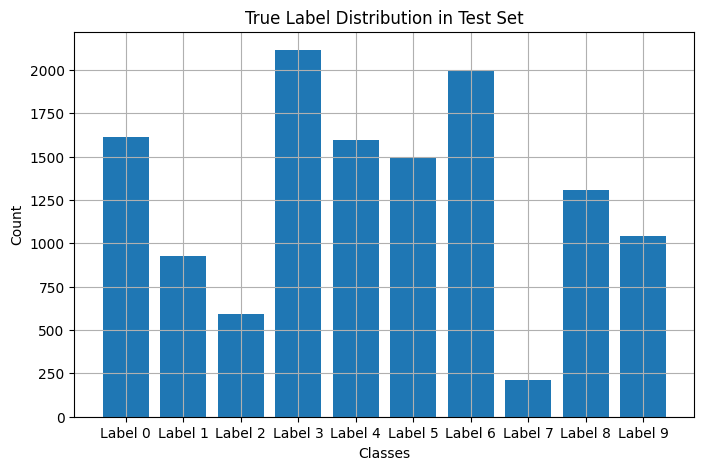

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count label distribution
classes, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar(classes, counts, tick_label=[f"Label {i}" for i in classes])
plt.title("True Label Distribution in Test Set")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.grid(True)
plt.show()

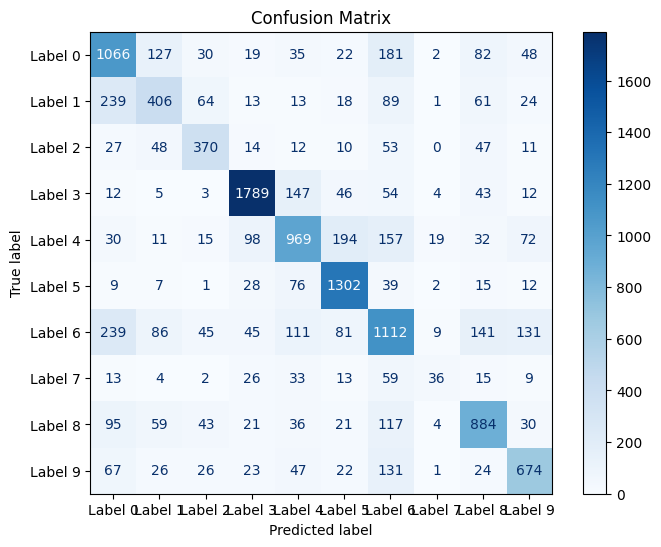

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Label {i}" for i in classes])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(labels, preds, target_names=[f"Label {i}" for i in classes])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Label 0       0.59      0.66      0.63      1612
     Label 1       0.52      0.44      0.48       928
     Label 2       0.62      0.62      0.62       592
     Label 3       0.86      0.85      0.85      2115
     Label 4       0.66      0.61      0.63      1597
     Label 5       0.75      0.87      0.81      1491
     Label 6       0.56      0.56      0.56      2000
     Label 7       0.46      0.17      0.25       210
     Label 8       0.66      0.67      0.67      1310
     Label 9       0.66      0.65      0.65      1041

    accuracy                           0.67     12896
   macro avg       0.63      0.61      0.61     12896
weighted avg       0.66      0.67      0.66     12896



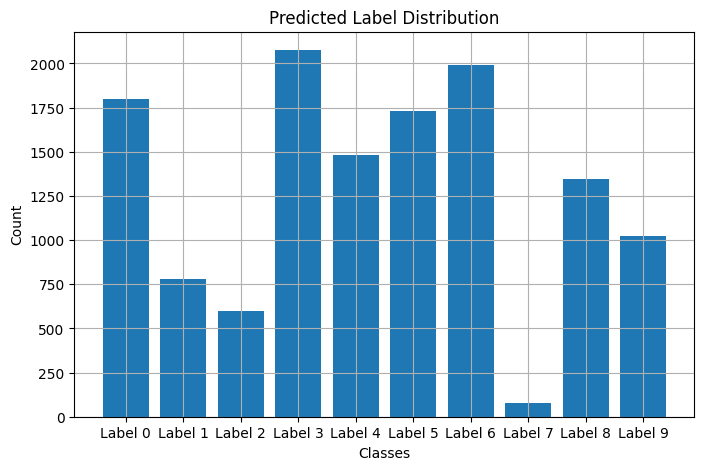

In [ ]:
pred_classes, pred_counts = np.unique(preds, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(pred_classes, pred_counts, tick_label=[f"Label {i}" for i in pred_classes])
plt.title("Predicted Label Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [ ]:
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json',
 './final_model/tokenizer.json')

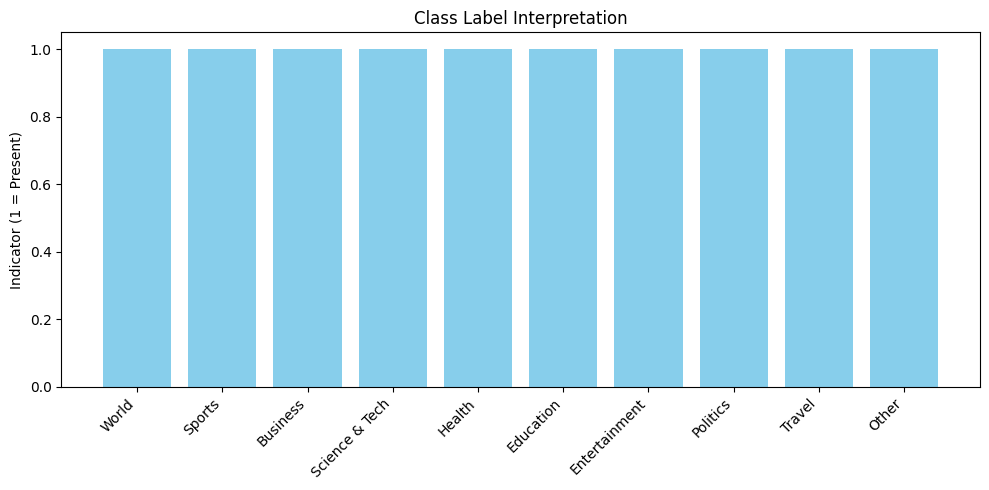

In [ ]:
import matplotlib.pyplot as plt

# Example class names (replace these with the correct ones for your dataset!)
class_labels = [
    "World", "Sports", "Business", "Science & Tech",
    "Health", "Education", "Entertainment", "Politics",
    "Travel", "Other"
]

plt.figure(figsize=(10, 5))
plt.bar(range(len(class_labels)), [1]*len(class_labels), tick_label=class_labels, color='skyblue')
plt.title("Class Label Interpretation")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Indicator (1 = Present)")
plt.tight_layout()
plt.show()


In [ ]:
def classify_text(text):
    output = pipeline(text)[0]
    for entry in output:
        print(f"{entry['label']} → {entry['score']:.4f}")


## Project Summary

This run trained a 10-class emotion classifier on the GoEmotions dataset, achieving:
- Accuracy: 66.75%
- Precision: 66.36%
- Recall: 66.75%
- F1: 66.33%

The notebook also prepares the EmpatheticDialogues dataset for the reader-perspective model by aligning labels to the same 10 emotions.  

This provides a complete pipeline for the author perspective and lays the groundwork for future reader-perspective modeling and divergence analysis.
